In [2]:
import heapq
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Node:
    def __init__(self, x, y, cost, pind):
        self.x = x  # x position of node
        self.y = y  # y position of node
        self.cost = cost  # g cost of node
        self.pind = pind  # parent index of node

In [4]:
class Para:
    def __init__(self, minx, miny, maxx, maxy, xw, yw, reso, motion):
        self.minx = minx
        self.miny = miny
        self.maxx = maxx
        self.maxy = maxy
        self.xw = xw
        self.yw = yw
        self.reso = reso  # resolution of grid world
        self.motion = motion  # motion set

In [5]:
def astar_planning(sx, sy, gx, gy, ox, oy, reso, rr):
    """
    return path of A*.
    :param sx: starting node x [m]
    :param sy: starting node y [m]
    :param gx: goal node x [m]
    :param gy: goal node y [m]
    :param ox: obstacles x positions [m]
    :param oy: obstacles y positions [m]
    :param reso: xy grid resolution
    :param rr: robot radius
    :return: path
    """

    n_start = Node(round(sx / reso), round(sy / reso), 0.0, -1)
    n_goal = Node(round(gx / reso), round(gy / reso), 0.0, -1)

    ox = [x / reso for x in ox]
    oy = [y / reso for y in oy]

    P, obsmap = calc_parameters(ox, oy, rr, reso)

    open_set, closed_set = dict(), dict()
    open_set[calc_index(n_start, P)] = n_start

    q_priority = []
    heapq.heappush(q_priority,
                   (fvalue(n_start, n_goal), calc_index(n_start, P)))

    while True:
        if not open_set:
            break

        _, ind = heapq.heappop(q_priority)
        n_curr = open_set[ind]
        closed_set[ind] = n_curr
        open_set.pop(ind)

        for i in range(len(P.motion)):
            node = Node(n_curr.x + P.motion[i][0],
                        n_curr.y + P.motion[i][1],
                        n_curr.cost + u_cost(P.motion[i]), ind)

            if not check_node(node, P, obsmap):
                continue

            n_ind = calc_index(node, P)
            if n_ind not in closed_set:
                if n_ind in open_set:
                    if open_set[n_ind].cost > node.cost:
                        open_set[n_ind].cost = node.cost
                        open_set[n_ind].pind = ind
                else:
                    open_set[n_ind] = node
                    heapq.heappush(q_priority,
                                   (fvalue(node, n_goal), calc_index(node, P)))

    pathx, pathy = extract_path(closed_set, n_start, n_goal, P)

    return pathx, pathy


In [6]:
def calc_holonomic_heuristic_with_obstacle(node, ox, oy, reso, rr):
    n_goal = Node(round(node.x[-1] / reso), round(node.y[-1] / reso), 0.0, -1)

    ox = [x / reso for x in ox]
    oy = [y / reso for y in oy]

    P, obsmap = calc_parameters(ox, oy, reso, rr)

    open_set, closed_set = dict(), dict()
    open_set[calc_index(n_goal, P)] = n_goal

    q_priority = []
    heapq.heappush(q_priority, (n_goal.cost, calc_index(n_goal, P)))

    while True:
        if not open_set:
            break

        _, ind = heapq.heappop(q_priority)
        n_curr = open_set[ind]
        closed_set[ind] = n_curr
        open_set.pop(ind)

        for i in range(len(P.motion)):
            node = Node(n_curr.x + P.motion[i][0],
                        n_curr.y + P.motion[i][1],
                        n_curr.cost + u_cost(P.motion[i]), ind)

            if not check_node(node, P, obsmap):
                continue

            n_ind = calc_index(node, P)
            if n_ind not in closed_set:
                if n_ind in open_set:
                    if open_set[n_ind].cost > node.cost:
                        open_set[n_ind].cost = node.cost
                        open_set[n_ind].pind = ind
                else:
                    open_set[n_ind] = node
                    heapq.heappush(q_priority, (node.cost, calc_index(node, P)))

    hmap = [[np.inf for _ in range(P.yw)] for _ in range(P.xw)]

    for n in closed_set.values():
        hmap[n.x - P.minx][n.y - P.miny] = n.cost

    return hmap

In [7]:
def check_node(node, P, obsmap):
    if node.x <= P.minx or node.x >= P.maxx or \
            node.y <= P.miny or node.y >= P.maxy:
        return False

    if obsmap[node.x - P.minx][node.y - P.miny]:
        return False

    return True


In [8]:
def u_cost(u):
    return math.hypot(u[0], u[1])


def fvalue(node, n_goal):
    return node.cost + h(node, n_goal)


def h(node, n_goal):
    return math.hypot(node.x - n_goal.x, node.y - n_goal.y)


def calc_index(node, P):
    return (node.y - P.miny) * P.xw + (node.x - P.minx)


def calc_parameters(ox, oy, rr, reso):
    minx, miny = round(min(ox)), round(min(oy))
    maxx, maxy = round(max(ox)), round(max(oy))
    xw, yw = maxx - minx, maxy - miny

    motion = get_motion()
    P = Para(minx, miny, maxx, maxy, xw, yw, reso, motion)
    obsmap = calc_obsmap(ox, oy, rr, P)

    return P, obsmap


def calc_obsmap(ox, oy, rr, P):
    obsmap = [[False for _ in range(P.yw)] for _ in range(P.xw)]

    for x in range(P.xw):
        xx = x + P.minx
        for y in range(P.yw):
            yy = y + P.miny
            for oxx, oyy in zip(ox, oy):
                if math.hypot(oxx - xx, oyy - yy) <= rr / P.reso:
                    obsmap[x][y] = True
                    break

    return obsmap


In [9]:
def extract_path(closed_set, n_start, n_goal, P):
    pathx, pathy = [n_goal.x], [n_goal.y]
    n_ind = calc_index(n_goal, P)

    while True:
        node = closed_set[n_ind]
        pathx.append(node.x)
        pathy.append(node.y)
        n_ind = node.pind

        if node == n_start:
            break

    pathx = [x * P.reso for x in reversed(pathx)]
    pathy = [y * P.reso for y in reversed(pathy)]

    return pathx, pathy


In [10]:
def get_motion():
    motion = [[-1, 0], [-1, 1], [0, 1], [1, 1],
              [1, 0], [1, -1], [0, -1], [-1, -1]]

    return motion


def get_env():
    ox, oy = [], []

    for i in range(60):
        ox.append(i)
        oy.append(0.0)
    for i in range(60):
        ox.append(60.0)
        oy.append(i)
    for i in range(61):
        ox.append(i)
        oy.append(60.0)
    for i in range(61):
        ox.append(0.0)
        oy.append(i)
    for i in range(40):
        ox.append(20.0)
        oy.append(i)
    for i in range(40):
        ox.append(40.0)
        oy.append(60.0 - i)

    return ox, oy


In [14]:
def main():
    sx = 10.0  # [m]
    sy = 10.0  # [m]
    gx = 50.0  # [m]
    gy = 50.0  # [m]

    robot_radius = 2.0
    grid_resolution = 1.0
    ox, oy = get_env()

    pathx, pathy = astar_planning(sx, sy, gx, gy, ox, oy, grid_resolution, robot_radius)

    plt.plot(ox, oy, 'sk')
    plt.plot(pathx, pathy, '-r')
    plt.plot(sx, sy, 'sg')
    plt.plot(gx, gy, 'sb')
    plt.axis("equal")
    plt.show()


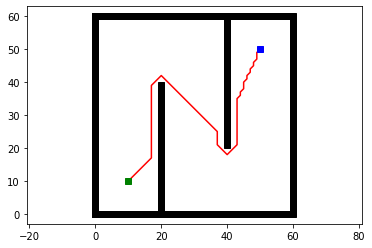

In [16]:
if __name__ == '__main__':
    main()